# Simple DQN agent

The notebook provides a quick training of [Deep Q-Network](https://arxiv.org/abs/1312.5602) (DQN) algorithm on the `WaterDistributionSystemEnv` environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
from collections import OrderedDict, defaultdict
from gymnasium.utils.env_checker import check_env
import gymnasium as gym

from gym4real.envs.wds.utils import parameter_generator

In [3]:
sns.set_theme()
sns.set_style('whitegrid')
sns.set_context("paper")
plot_colors = sns.color_palette('colorblind')
sns.set(font_scale=1.2)

alg_color = OrderedDict({
    'random': plot_colors[1],
    'dqn': plot_colors[0],
})

## DQN Agent
We are adopting the Stable-Baselines 3 version of DQN, described [here](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html).

Here we initialize both the environment for training the agent and the environment to evaluate the agent. Indeed, the evaluation is done on an environment which presents different consumption profiles. The evaluation is done on 5 profiles.

In [4]:
# Uncomment this line to install stable-baselines3
#!pip install stable-baselines3

In [5]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from gym4real.envs.wds.env import WaterDistributionSystemEnv

In [6]:
n_episodes = 10
n_envs = 1

In [7]:
params = parameter_generator(hydraulic_step=3600, duration=3600*24*7, seed=42)
env = make_vec_env('gym4real/wds-v0', n_envs=n_envs, env_kwargs={'settings':params})

/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/envs/registration.py:734: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [8]:
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=env.get_attr('_duration')[0] * n_episodes / 3600, 
            progress_bar=True)
model.save('examples/wds/trained_models/DQN_quick')

Output()

Resetting the environment...


Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

Resetting the environment...

## Comparison with Random policy
Here we will compare the DQN model saved with a simple random policy. The policies will be compared on several test profiles and a different seed wrt the train.

In [9]:
eval_params = parameter_generator(hydraulic_step=3600, duration=3600*24*7, seed=1234)
env = gym.make(id="gym4real/wds-v0", **{'settings':eval_params})
n_episodes = 20
rewards = {}

/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Random Policy
The action is chosen randomly at each decision step.

In [10]:
alg = 'random'
rewards[alg] = {}

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset(options={'is_evaluation': True})
    done = False
    cumulated_reward = 0
    rewards[alg][episode] = []
    
    while not done:
        action = env.action_space.sample()  # Randomly select an action
        obs, reward, terminated, truncated, info = env.step(action)  
        done = terminated or truncated
        cumulated_reward += reward
        rewards[alg][episode].append(cumulated_reward)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.87s/it]


### DQN agent
Here we load the previously trained model `DQN_quick`.

In [11]:
env = make_vec_env("gym4real/wds-v0", n_envs=1, env_kwargs={'settings':eval_params})

alg = 'dqn'
rewards[alg] = {}

model = DQN('MlpPolicy', env, verbose=1)
vec_env = model.get_env()
model = DQN.load("examples/wds/trained_models/DQN_quick")

for episode in tqdm(range(n_episodes)):
    vec_env.set_options({'is_evaluation': True})
    obs = vec_env.reset()

    cumulated_reward = 0
    rewards[alg][episode] = []
    done = False
    
    while not done:
        action, _states = model.predict(obs)
        obs, r, dones, info = vec_env.step(action)
        done = dones[0]
        cumulated_reward += r[0]
        rewards[alg][episode].append(cumulated_reward)

/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/envs/registration.py:734: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/dave/miniconda3/envs/osx-64/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 16/20 [01:59<00:29,  7.46s/it]/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/gym4ReaL/gym4real/envs/wds/simulator/epynet/epanet2.py:683: UserWarning: WARNING: Pumps cannot deliver enough flow or head.
  warnings.warn(self.ENgeterror(ierr))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.50s/it]


Let's compare the cumulative rewards averaged among the test profiles between `DQN` undergone a quick training and the `random` policy.

In [12]:
# Notice that since the episodes do not have the same length (due to internal simulator steps), 
# we have to consider the samples referring to the same elapsed time.
"""
rewards_same_len = {}

for alg in rewards.keys():
    # Get the set of times for each profile
    profile_times = []
    for profile in rewards[alg].values():
        times = set([entry[0] for entry in profile])
        profile_times.append(times)
    
    # Find common times across all profiles
    common_times = sorted(set.intersection(*profile_times))

    # Filter each profile to keep only entries with times in common_times
    rewards_same_len[alg] = {}
    for key, values in rewards[alg].items():
        filtered = [val[1] for val in values if val[0] in common_times]
        rewards_same_len[alg][key] = filtered
"""

'\nrewards_same_len = {}\n\nfor alg in rewards.keys():\n    # Get the set of times for each profile\n    profile_times = []\n    for profile in rewards[alg].values():\n        times = set([entry[0] for entry in profile])\n        profile_times.append(times)\n\n    # Find common times across all profiles\n    common_times = sorted(set.intersection(*profile_times))\n\n    # Filter each profile to keep only entries with times in common_times\n    rewards_same_len[alg] = {}\n    for key, values in rewards[alg].items():\n        filtered = [val[1] for val in values if val[0] in common_times]\n        rewards_same_len[alg][key] = filtered\n'

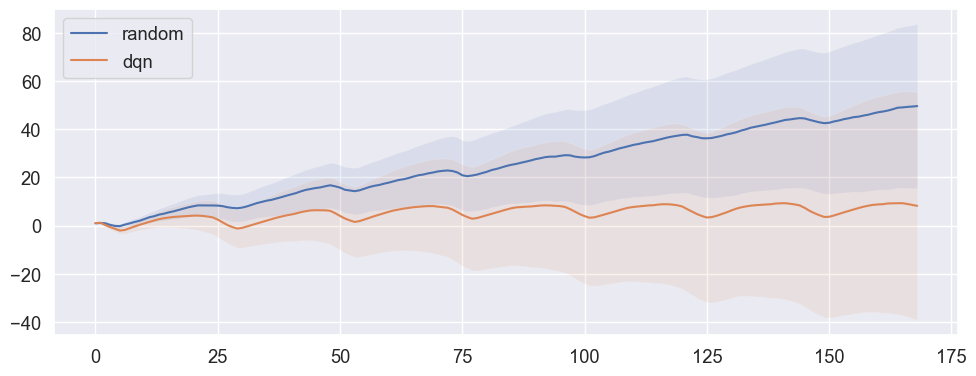

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), tight_layout=True)

for i, alg in enumerate(rewards.keys()):
    means = np.mean([rewards[alg][episode] for episode in rewards[alg].keys()], axis=0)
    stds = np.std([rewards[alg][episode] for episode in rewards[alg].keys()], axis=0)
    ci = 1.96 * stds/np.sqrt(len(rewards[alg].keys()))
    
    ax.plot(means, label=alg)        
    ax.fill_between(range(len(means)), means + ci, means - ci, alpha=0.1)
    ax.legend()